In [1]:
import pandas as pd
import numpy as np
import itertools 
import heapq

class Node:
    def __init__(self, state, g=0, f=0):
        self.state = state
        self.g = g
        self.f = f
        self.parent = None  # Important for path reconstruction

    def __hash__(self):
        # Convert state dict to a hashable representation
        # Only consider the key state variables that affect goal checking
        key_vars = ['soil_moisture', 'ph', 'N', 'P', 'K']
        return hash(tuple((k, round(self.state[k], 2)) for k in key_vars if k in self.state))

    def __eq__(self, other):
        if not isinstance(other, Node):
            return False
            
        # Compare only key state variables
        key_vars = ['soil_moisture', 'ph', 'N', 'P', 'K']
        for k in key_vars:
            if k in self.state and k in other.state:
                # Round to handle floating point comparisons
                if round(self.state[k], 2) != round(other.state[k], 2):
                    return False
        return True

    # Add these comparison methods
    def __lt__(self, other):
        # Compare nodes based on f-score (total cost)
        return self.f < other.f

    def __gt__(self, other):
        return self.f > other.f

    def copy(self):
        new_node = Node(self.state.copy(), self.g, self.f)
        new_node.parent = self.parent
        return new_node

In [2]:
import pandas as pd
import numpy as np

class GoalState:
    def __init__(self):
        self.df = None
        self.optimal_soil_moisture = None
        self.optimal_ph = None
        self.optimal_n = None
        self.optimal_p = None
        self.optimal_k = None

    def estimate_optimal_params(self, label, growth_stage, soil_type, crop_density_input, df,density_tolerance=2):
        self.df = df
        growth_stage = int(growth_stage)
        soil_type = int(soil_type)

        filtered = df[
            (df['label'].str.lower() == label.lower()) &
            (df['growth_stage'] == growth_stage) &
            (df['soil_type'] == soil_type) &
            (np.abs(df['crop_density'] - crop_density_input) <= density_tolerance)
        ]

        if filtered.empty:
                filtered = df[
                (df['label'].str.lower() == label.lower()) &
                (df['growth_stage'] == growth_stage) &
                (df['soil_type'] == soil_type) 
            ]
          

        filtered2 = df[
            (df['label'].str.lower() == label.lower()) &
            (df['growth_stage'] == growth_stage) &
            (df['soil_type'] == soil_type)
        ]

        env_features = ['rainfall', 'humidity', 'temperature', 'sunlight_exposure']
        env_avgs = filtered2[env_features].mean()
        print("\n Environmental Averages from Dataset:")
        for feature in env_features:
            print(f"  • {feature.title()}: {env_avgs[feature]:.2f}")

        original_soil_moisture_avg = filtered['soil_moisture'].mean()
        original_soil_moisture_std = filtered['soil_moisture'].std()
        self.optimal_ph = filtered['ph'].mean()
        self.optimal_n = filtered['N'].mean()
        self.optimal_p = filtered['P'].mean()
        self.optimal_k = filtered['K'].mean()

        print(f"\n Average Original Soil Moisture: {original_soil_moisture_avg:.2f}%")
        print(f"\n Standard Deviation of Original Soil Moisture: {original_soil_moisture_std:.2f}%")
        def adjust_soil_moisture(row):
            adj = row['soil_moisture']
            if original_soil_moisture_std < 3:
                return adj

            rain_diff = row['rainfall'] - env_avgs['rainfall']
            humidity_diff = row['humidity'] - env_avgs['humidity']
            temp_diff = row['temperature'] - env_avgs['temperature']
            sun_diff = row['sunlight_exposure'] - env_avgs['sunlight_exposure']

            if soil_type == 1:
                if growth_stage == 1:
                    adj -= 0.02 * rain_diff
                    adj -= 0.6 * humidity_diff
                    adj += 0.8 * temp_diff
                    adj += 1.2 * sun_diff
                elif growth_stage == 2:
                    adj -= 0.02 * rain_diff
                    adj -= 0.7 * humidity_diff
                    adj += 0.75 * temp_diff
                    adj += 1.3 * sun_diff
                else:
                    adj -= 0.02 * rain_diff
                    adj -= 0.8 * humidity_diff
                    adj += 1.4 * temp_diff
                    adj += 1.1 * sun_diff

            elif soil_type == 2:
                if growth_stage == 1:
                    adj -= 0.03 * rain_diff
                    adj -= 0.06 * humidity_diff
                    adj += 0.15 * temp_diff
                    adj += 0.25 * sun_diff
                elif growth_stage == 2:
                    adj -= 0.035 * rain_diff
                    adj -= 0.07 * humidity_diff
                    adj += 0.28 * temp_diff
                    adj += 0.28 * sun_diff
                else:
                    adj -= 0.04 * rain_diff
                    adj -= 0.08 * humidity_diff
                    adj += 0.3 * temp_diff
                    adj += 0.3 * sun_diff

            else:
                if growth_stage == 1:
                    adj -= 0.02 * rain_diff
                    adj -= 0.6 * humidity_diff
                    adj += 0.1 * temp_diff
                    adj += 1.2 * sun_diff
                elif growth_stage == 2:
                    adj -= 0.02 * rain_diff
                    adj -= 0.7 * humidity_diff
                    adj += 0.4 * temp_diff
                    adj += 1.3 * sun_diff
                else:
                    adj -= 0.02 * rain_diff
                    adj -= 0.8 * humidity_diff
                    adj += 0.4 * temp_diff
                    adj += 1.4 * sun_diff

            return adj

        filtered = filtered.copy()
        filtered['Adjusted Soil Moisture'] = filtered.apply(adjust_soil_moisture, axis=1)

        print("\n Adjusted Soil Moisture Values:")
        print(filtered['Adjusted Soil Moisture'].values)

        self.optimal_soil_moisture = np.average(
            filtered['Adjusted Soil Moisture'],
            weights=1 / filtered['water_usage_efficiency']
        )

        print(f"\n Weighted Optimal Soil Moisture (favoring low WUE): {self.optimal_soil_moisture:.2f}%")
        print(f" Std Dev (Adjusted): {filtered['Adjusted Soil Moisture'].std():.2f}%")
        print(f" Estimated Optimal Soil Moisture (normal average): {filtered['Adjusted Soil Moisture'].mean():.2f}%")
        
        print(f" Estimated Optimal N   : {self.optimal_n:.2f}")
        print(f" Estimated Optimal P   : {self.optimal_p:.2f}")
        print(f" Estimated Optimal K   : {self.optimal_k:.2f}")

        return self.optimal_soil_moisture



In [3]:
import random

class optimization_problem:
    def __init__(self, initial_state, df):
        self.df = df
        self.initial_state = initial_state
        self.transition_model = self._transition_model()
        
        goal = GoalState()
        
        goal.estimate_optimal_params(
            self.initial_state['label'],
            self.initial_state['growth_stage'],
            self.initial_state['soil_type'],
            self.initial_state['crop_density'], 
            self.df, 
        )
        self.goal = goal
        self.optimal_ranges = {
            'soil_moisture': (self.goal.optimal_soil_moisture - 2.5, self.goal.optimal_soil_moisture + 2.5),
            'ph': (self.goal.optimal_ph - 1, self.goal.optimal_ph + 1),
            'N': (self.goal.optimal_n - 2.5, self.goal.optimal_n + 2.5),
            'P': (self.goal.optimal_p - 2.5, self.goal.optimal_p + 2.5),
            'K': (self.goal.optimal_k - 2.5, self.goal.optimal_k + 2.5),
        }

    def in_range(self, actual, target, tolerance):
        return abs(actual - target) <= tolerance

    def goalstate(self, node):
        # Check if the state matches our goal conditions
        moisture_in_range = self.in_range(node.state['soil_moisture'], self.goal.optimal_soil_moisture, 2.5)
        ph_in_range = self.in_range(node.state['ph'], self.goal.optimal_ph, 3)
        n_in_range = self.in_range(node.state['N'], self.goal.optimal_n, 2.5)
        p_in_range = self.in_range(node.state['P'], self.goal.optimal_p, 2.5)
        k_in_range = self.in_range(node.state['K'], self.goal.optimal_k, 2.5)
        
        # Debug output to see what's happening
        print("\nChecking if goal state:")
        print(f"  Soil Moisture: {node.state['soil_moisture']:.2f} -> Target: {self.goal.optimal_soil_moisture:.2f} ± 2.5 -> In range: {moisture_in_range}")
        print(f"  pH: {node.state['ph']:.2f} -> Target: {self.goal.optimal_ph:.2f} ± 1.0 -> In range: {ph_in_range}")
        print(f"  N: {node.state['N']:.2f} -> Target: {self.goal.optimal_n:.2f} ± 2.5 -> In range: {n_in_range}")
        print(f"  P: {node.state['P']:.2f} -> Target: {self.goal.optimal_p:.2f} ± 2.5 -> In range: {p_in_range}")
        print(f"  K: {node.state['K']:.2f} -> Target: {self.goal.optimal_k:.2f} ± 2.5 -> In range: {k_in_range}")
        
        is_goal = moisture_in_range and ph_in_range and n_in_range and p_in_range and k_in_range
        print(f"  Is goal state: {is_goal}")
        
        return is_goal

    def priorities(self):
        s = self.initial_state  # shorthand

        water_priority = 0.33
        fertilizer_priority = 0.33
        irrigation_frequency_priority = 0.33

        # Growth stage
        if s['growth_stage'] == 1:
            water_priority += 0.1
            fertilizer_priority += 0.05
            irrigation_frequency_priority += 0.1
        elif s['growth_stage'] == 2:
            fertilizer_priority += 0.15
            water_priority += 0.05
        elif s['growth_stage'] == 3:
            water_priority += 0.15
            fertilizer_priority += 0.1
            irrigation_frequency_priority += 0.05

        # Soil type
        soil_type = str(s['soil_type'])
        if soil_type == "1":
            irrigation_frequency_priority += 0.15
            water_priority += 0.1
        elif soil_type == "3":
            irrigation_frequency_priority -= 0.1
            water_priority -= 0.05
            fertilizer_priority += 0.05

        # Temperature effects
        heat_stress = max(0, min(1, (s['temperature'] - 25) / 15))
        water_priority += heat_stress * 0.2
        irrigation_frequency_priority += heat_stress * 0.15

        # Humidity effects
        water_priority -= (s['humidity'] / 100) * 0.1

        # Soil moisture effects
        drought_factor = max(0, 1 - (s['soil_moisture'] / 0.2))
        water_priority += drought_factor * 0.25
        irrigation_frequency_priority += drought_factor * 0.2

        # Ensure priorities don't go below minimum values
        return {
            'water_priority': max(0.33, min(1.0, water_priority)),
            'fertilizer_priority': max(0.33, min(1.0, fertilizer_priority)),
            'irrigation_frequency_priority': max(0.33, min(1.0, irrigation_frequency_priority))
        }

    def optimal_distance_calc(self, var, value):
        min_val, max_val = self.optimal_ranges[var]
        if value < min_val:
            return min_val - value
        elif value > max_val:
            return value - max_val
        return 0

    def heuristic(self, state):
        p = self.priorities()
        deviation_score = 0
        
        # Only consider parameters that are outside their optimal ranges
        if not (self.optimal_ranges['soil_moisture'][0] <= state['soil_moisture'] <= self.optimal_ranges['soil_moisture'][1]):
            deviation_score += p['water_priority'] * self.optimal_distance_calc('soil_moisture', state['soil_moisture'])
        
        nutrient_priority = p['fertilizer_priority']
        for nutrient in ['N', 'P', 'K']:
            if not (self.optimal_ranges[nutrient][0] <= state[nutrient] <= self.optimal_ranges[nutrient][1]):
                deviation_score += nutrient_priority * self.optimal_distance_calc(nutrient, state[nutrient])
        
        # Only consider irrigation if soil moisture needs adjustment
        if not (self.optimal_ranges['soil_moisture'][0] <= state['soil_moisture'] <= self.optimal_ranges['soil_moisture'][1]):
            deviation_score += p['irrigation_frequency_priority']
        
        return deviation_score

    def get_valid_actions(self, state):
        valid_actions = []
        
        # Determine which parameters need adjustment
        needs_adjustment = {
            'soil_moisture': not (self.optimal_ranges['soil_moisture'][0] <= state['soil_moisture'] <= self.optimal_ranges['soil_moisture'][1]),
            'N': not (self.optimal_ranges['N'][0] <= state['N'] <= self.optimal_ranges['N'][1]),
            'P': not (self.optimal_ranges['P'][0] <= state['P'] <= self.optimal_ranges['P'][1]),
            'K': not (self.optimal_ranges['K'][0] <= state['K'] <= self.optimal_ranges['K'][1]),
            'irrigation': not (self.optimal_ranges['soil_moisture'][0] <= state['soil_moisture'] <= self.optimal_ranges['soil_moisture'][1])
        }
        
        # Generate base action with no changes
        base_action = {
            "water_added": 0,
            "N_added": 0,
            "P_added": 0,
            "K_added": 0,
            "irrigation_update": 0
        }
        
        # If no parameters need adjustment, return only the base action
        if not any(needs_adjustment.values()):
            return [base_action]
        
        # Generate possible actions only for parameters that need adjustment
        water_options = [-3, -2, 0, 2, 3] if needs_adjustment['soil_moisture'] else [0]
        N_options = [-3, 0, 3, 6] if needs_adjustment['N'] else [0]
        P_options = [-3, 0, 3, 6] if needs_adjustment['P'] else [0]
        K_options = [-3, 0, 3, 6] if needs_adjustment['K'] else [0]
        
        for water, n, p, k in itertools.product(water_options, N_options, P_options, K_options):
            action = {
                "water_added": water,
                "N_added": n,
                "P_added": p,
                "K_added": k,
            }
            
            # Additional validation to ensure actions make sense
            valid = True
            
            # Soil moisture
            if needs_adjustment['soil_moisture']:
                current = state['soil_moisture']
                target = self.goal.optimal_soil_moisture
                if current < target and water <= 0:
                    valid = False
                if current > target and water >= 0:
                    valid = False
            
            # Nutrients
            for nutrient, val in zip(['N', 'P', 'K'], [n, p, k]):
                if needs_adjustment[nutrient]:
                    current = state[nutrient]
                    target = getattr(self.goal, f'optimal_{nutrient.lower()}')
                    if current < target and val <= 0:
                        valid = False
                    if current > target and val >= 0:
                        valid = False

            if valid:
                valid_actions.append(action)
        
        return valid_actions
    
    def evaporation_factor(self):
        daily_moisture_loss = 0.3 * self.initial_state['temperature'] + 0.1 * self.initial_state['sunlight_exposure'] + 0.04 * self.initial_state['wind_speed'] + 0.01 *(100-self.initial_state['humidity']) * self.initial_state['soil_type'] * self.initial_state['growth_stage']
        return max(daily_moisture_loss, 0.01)  # prevent zero or negative values
    
    def calculate_drought_time(self, node):
        goal_node =  node.copy()
        moisture_difference = goal_node.state['soil_moisture'] - self.initial_state['soil_moisture']
        soil_reset_duration = moisture_difference / self.evaporation_factor()
        return   max(soil_reset_duration, 0.1)
    
    def get_irrigation_frequency(self, node):
     
     #### if the irrigation frequency > 7 this means : (evaporation_factor > moisture_difference )
     #### in this case i will set the irrigation frequency to 7
     #### this will affect initia soil moisture such that 
     ### i could calculte how much the soil moisture initial should be so 
     ### i could irrigate only once a day in this evaporation_factor 
     ### this simply means new_deffrence of the soil moisture (between the goal and the new initial state )
     # should be equal to the evaporation_factor  
     ### goal_soil_moisture - new_initial_moisture = evaporation factor => new_initial_moisture = goal_soil_moisture - evaporation factor

     if ((7 / self.calculate_drought_time(node)) > 7 ) :
        goal_node =  node.copy()  
        moisture_decrease_per_day = self.evaporation_factor()
        new_soil_moisture = goal_node.state['soil_moisture'] - moisture_decrease_per_day  
        self.initial_state["soil_moisture"] = max(new_soil_moisture , 3)  
        return 7 
     else : 
         return int( 7 / self.calculate_drought_time(node) )
        

    def apply_action(self, node, action):
        soil_type = str(node.state['soil_type'])
        water_source = str(node.state['water_source'])
        new_node = node.copy()
        
        # Only apply water if soil moisture needs adjustment
        if not (self.optimal_ranges['soil_moisture'][0] <= node.state['soil_moisture'] <= self.optimal_ranges['soil_moisture'][1]):
            moisture_per_L = self.transition_model["add_water"]["soil_moisture_increase_per_L"][soil_type]
            delta_moisture = action["water_added"] * moisture_per_L
            new_node.state['soil_moisture'] += delta_moisture
            ##### impact on ph level#####
            new_node.state["ph"] += self.transition_model["add_water"]["ph_change_per_L_by_water_source"][water_source][soil_type]
            uptake_per_1pct = self.transition_model["add_water"]["npk_uptake_increase_per_1_percent_moisture"][soil_type]
            for nutrient in ['N', 'P', 'K']:
                new_node.state[nutrient] += delta_moisture * uptake_per_1pct[nutrient]
            new_node.state['water_used'] += action["water_added"]
        
        # Only apply fertilizer if nutrient needs adjustment
        for nutrient in ['N', 'P', 'K']:
            if not (self.optimal_ranges[nutrient][0] <= node.state[nutrient] <= self.optimal_ranges[nutrient][1]):
                new_node.state[nutrient] += action[f"{nutrient}_added"]
                ####impact on ph level of the soil#####
                new_node.state['ph']+= action[f"{nutrient}_added"] * self.transition_model["add_fertilizer"]["ph_change_per_application"][nutrient][soil_type]
                new_node.state['fertilizer_used'] += action[f"{nutrient}_added"] * new_node.state[f"{nutrient}_percentage"]
        
        return new_node
    

    def expand_node(self, node):
        children = []
        for action in self.get_valid_actions(node.state):
            new_node = self.apply_action(node, action)
            g_cost = self.cost_function(node.state, action)
            h = self.heuristic(new_node.state)
            new_node.g = node.g + g_cost
            new_node.f = new_node.g + h
            new_node.parent = node
            children.append(new_node)
        return children
    
    def reconstruct_path(self, node):
        path = []
        while node:
            path.append(node)
            node = node.parent
        return path[::-1]  # Reverse to get start-to-goal order
    
    def calculate_moisture_increase(self,soil_type, depth_cm=30):

        soil_types = {
        "Sandy": {"bulk_density": 1.43},  # g/cm³
        "Loamy": {"bulk_density": 1.43},  # g/cm³
        "Clay": {"bulk_density": 1.33}    # g/cm³
        }

        """
        Calculate how much 1L of water will increase soil moisture in 1m² area
        
        Parameters:
        - soil_type: "Sandy", "Loamy", or "Clay"
        - depth_cm: Soil depth in centimeters (default 30cm)
        
        Returns:
        - Moisture increase percentage
        """
        water_volume_cm3 = 1000  # 1L water = 1000 cm³
        area_cm2 = 10000         # 1m² = 10000 cm²
        soil_volume_cm3 = area_cm2 * depth_cm
        bulk_density = soil_types[soil_type]["bulk_density"]
        soil_mass_g = soil_volume_cm3 * bulk_density
        moisture_increase = (water_volume_cm3 / soil_mass_g) * 100
        return round(moisture_increase, 2)
    

    def _transition_model(self):
    # Calculate moisture increases for each soil type (1: Sandy, 2: Loamy, 3: Clay)
        return {
            "add_water": {
                "units": "1 L/m²",
                "soil_moisture_increase_per_L": {
                    "1": self.calculate_moisture_increase("Sandy"),
                    "2": self.calculate_moisture_increase("Loamy"),
                    "3": self.calculate_moisture_increase("Clay")
                },
                "npk_uptake_increase_per_1_percent_moisture": {
                    "1": {"N": 0.2, "P": 0.15, "K": 0.18},
                    "2": {"N": 0.25, "P": 0.2, "K": 0.22},
                    "3": {"N": 0.15, "P": 0.25, "K": 0.2}
                },
                "ph_change_per_L_by_water_source": {
                    
                    "1": {"1": -0.01, "2": -0.015, "3": -0.01},   
                    "2": {"1": 0.01, "2": 0.015, "3": 0.01}, 
                    "3": {"1": -0.02, "2": -0.025, "3": -0.02}   
                }
            },
            "add_fertilizer": {
                "units": "per application",
                "ph_change_per_application": {
                    # Based on general acidifying potential
                    "N": {"1": 0.01, "2": 0.015, "3": 0.01},
                    "P": {"1": -0.01, "2": -0.015, "3": -0.01},
                    "K": {"1": 0.00, "2": 0.00, "3": 0.00},
                }
            }
        }

    def get_availability_level(self,used_amount, max_available):
        if max_available == 0:  # Avoid division by zero
            return "low"  # No availability if max is zero
        
        ratio = used_amount / max_available
        
        if ratio < 0.25:
            return "high"    # Only a small fraction used → plenty left
        elif ratio <= 0.75:
            return "medium"  # Moderate usage
        else:
            return "low"     # Most of the resource is used
        

    def cost_function(self, state, action):
    # Extract available resources (assumed to be in state)
        max_water_available = state.get("max_water_per_irrigation", 0)
        max_fert_available = state.get("max_fertilizer_per_application", 0)
        
        # Extract actual usage from action
        water_used = action["water_added"]
        fert_used = action["N_added"] + action["P_added"] + action["K_added"]
        
        # Determine availability levels
        wa = self.get_availability_level(water_used, max_water_available)
        fa = self.get_availability_level(fert_used, max_fert_available)
        
        # Calculate cost based on availability
        if (wa == "high" and fa == "high"):
            return water_used + fert_used * 2  # Cheaper when resources are available
        elif (wa == "medium" and fa == "medium"):
            return water_used + fert_used * 1.5
        elif (wa == "low" or fa == "low"):
            return water_used * 2 + fert_used * 3  # Higher cost when resources are scarce
        else:
            return water_used + fert_used  # Default cost

    def _generate_random_state(self):
        """
        Generates a random state dictionary with the following parameters:
        - Water_applied: ranges from -10 to 100 (represents water volume/amount)
        - N_applied: ranges from 0 to 100 (represents nitrogen application)
        - p_applied: ranges from 0 to 100 (represents phosphorus application)
        
        Returns:
            dict: A dictionary with random values for the specified parameters
        """
        state = {
            'water_added': random.uniform(-10, 100),
            'N_added': random.uniform(0, 100),
            'K_added': random.uniform(0,100),
            'P_added': random.uniform(0, 100)
        }
    
        return state



In [4]:
class GeneticAlgorithm:
    def __init__(self, problem, population_size=50, generations=1000, mutation_rate=0.1, tournament_size=3,
                 selection_method='tournament', crossover_method='pmx', mutation_method='swap'):
        
        self.problem = problem
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.tournament_size = tournament_size
        self.selection_method = selection_method
        self.crossover_method = crossover_method
        self.mutation_method = mutation_method

    def initialize_population(self):
        # Creates an initial population using the problem's _generate_random_state() method.
        population = []
        for _ in range(self.population_size):
            population.append(self.problem._generate_random_state())
        return population

    def evolve_population(self, population):
        
        # Find the best individual (elitism)
        best_individual = min(population, key=lambda x: self.evaluate(x))
        
        # Create new population with the best individual
        new_population = [best_individual.copy()]
        
        # Fill the rest of the population with offspring
        while len(new_population) < self.population_size:
            # Select parents
            parent1 = self.select_parent(population)
            parent2 = self.select_parent(population)
            
            # Create offspring through crossover
            child = self.perform_crossover(parent1, parent2)
            
            # Apply mutation with probability mutation_rate
            if random.random() < self.mutation_rate:
                child = self.perform_mutation(child)
                
            # Add child to new population
            new_population.append(child)
            
        return new_population

    def select_parent(self, population):
        # Selects a parent using the specified selection method.
        if self.selection_method == 'tournament':
            return self.tournament_selection(population, self.tournament_size)
        elif self.selection_method == 'roulette':
            return self.roulette_wheel_selection(population)
        else:
            # Default to tournament selection if unknown.
            return self.tournament_selection(population, self.problem, self.tournament_size)

    def perform_crossover(self, parent1, parent2):
        # Performs crossover between two parents using the specified method.
        if self.crossover_method == 'order':
            return self.order_crossover(parent1, parent2)
    
    def evaluate(self,individual):
        new_node = Node(self.problem.initial_state)
        potential_goal = self.problem.apply_action(new_node,individual)
        return self.problem.heuristic(potential_goal.state) 
    
    def perform_mutation(self, individual):
        # Applies mutation to an individual using the specified mutation method.
        return self.mutate(individual)
    def tournament_selection(self,population, tournament_size):
        """Selects an individual using tournament selection."""
        # Randomly select tournament_size individuals
        tournament = random.sample(population, tournament_size)
        
        # Return the best individual from the tournament
        return min(tournament, key=lambda x: self.evaluate(x)).copy()
    def roulette_wheel_selection(self,population):
        """Selects an individual using roulette wheel selection."""
        # Calculate fitness values (lower cost = higher fitness)
        fitness_values = [1.0 / (self.evaluate(individual) + 1e-10) for individual in population]
        total_fitness = sum(fitness_values)
        
        # Normalize fitness values to create probability distribution
        probabilities = [fitness / total_fitness for fitness in fitness_values]
        
        # Select an individual based on probabilities
        selected_index = random.choices(range(len(population)), weights=probabilities, k=1)[0]
        return population[selected_index].copy()
    
    def order_crossover(self, parent1, parent2):
        """
        Order Crossover (OX) adapted for dictionary-based representations.
        Each parent is a dictionary with keys representing parameters.
        """
        # Create a new offspring dictionary
        offspring = {}
        
        # Get all keys from the parent dictionary
        keys = list(parent1.keys())
        
        # Choose a random subset of keys to inherit from parent1
        num_keys = len(keys)
        num_to_inherit = random.randint(1, num_keys - 1)
        keys_from_parent1 = random.sample(keys, num_to_inherit)
        
        # Copy values for selected keys from parent1
        for key in keys_from_parent1:
            offspring[key] = parent1[key]
        
        # Copy remaining values from parent2
        for key in keys:
            if key not in offspring:
                offspring[key] = parent2[key]
        
        return offspring
    def mutate( self,individual):
        """Mutate one parameter of the action (values now range from 0 to 100)"""
        mutated = individual.copy()
        param = random.choice(["water_added", "N_added", "P_added", "K_added"])
        
        # Possible mutation steps (can be adjusted)
        mutation_steps = [-20, -10, -5, 5, 10, 20]
        
        current_val = mutated[param]
        
        # Apply mutation while clamping between 0 and 100
        step = random.choice(mutation_steps)
        new_val = max(0, min(100, current_val + step))  # Clamp to [0, 100]
        
        # Ensure the value actually changes (avoid no-op mutations)
        while new_val == current_val:
            step = random.choice(mutation_steps)
            new_val = max(0, min(100, current_val + step))
        
        mutated[param] = new_val
        return mutated
    def solve(self):
       
        # Initialize population
        population = self.initialize_population()
        print("\ninitial_population")
        for i in range(len(population)):
            print(population[i])
        
        # Track the best solution found so far
        best_solution = None
        best_cost = float('inf')
        
        # Evolution loop
        for generation in range(self.generations):
            # Evolve population
            population = self.evolve_population(population)
            
            # Find current best solution
            current_best = min(population, key=lambda x: self.evaluate(x))
            current_cost = self.evaluate(current_best)
            
            # Update overall best if necessary
            if current_cost < best_cost:
                best_solution = current_best.copy()
                best_cost = current_cost
            
            # Print progress every 100 generations
            if generation % 100 == 0:
                print(f"Generation {generation}: Best cost = {best_cost}")
                
            # After evolution, print the final optimized resources
        if best_solution is not None:
            print("\nResource Optimization Results:")
            # Create final state by copying initial state
            final_state = Node(self.problem.initial_state.copy()) 
            action = {
                'water_added': best_solution['water_added'],
                'N_added': best_solution['N_added'],
                'P_added': best_solution['P_added'],
                'K_added': best_solution['K_added']
            }
            self.problem.apply_action(final_state, action)

            final_state.state['water_used'] = best_solution['water_added']
            final_state.state['fertilizer_used'] = (
                best_solution['N_added'] * self.problem.initial_state['N_percentage'] +
                best_solution['P_added'] * self.problem.initial_state['P_percentage'] +
                best_solution['K_added'] * self.problem.initial_state['K_percentage']
            )
            final_state.state['irrigation_frequency'] = self.problem.get_irrigation_frequency(final_state)
            
            if final_state.state['water_used'] < 0:
                print("Optimal amount of water: Reduce the water usage by", round(abs(final_state.state['water_used']), 2), "L")
            else:
                print("Optimal amount of water: Add", round(final_state.state['water_used'], 2), "L")
                print("Optimal amount of fertilizer: Add", round(final_state.state['fertilizer_used'], 2), "KG")
            
            print("Optimal frequency of irrigation: Irrigate", round(final_state.state['irrigation_frequency']), "times per week")
        # Return the best solution found
        return best_solution, best_cost

# Helper functions for selection, crossover, and mutation



In [5]:


from goal_state import GoalState


class CSPProblem: 
    def __init__(self, initial_state , df, max_N, max_P, max_K, max_water):
          ### the constructor 
        
        self.max_N = max_N
        self.max_P = max_P
        self.max_K = max_K
        self.max_water = max_water

        self.df = df  
                        ### uncomment this if you want to add by 1        
        # domains = {
        #     'water_amount': list(range(0, 100)),
        #     'N': list(range(0, 101)),
        #     'P': list(range(0, 101)),
        #     'K': list(range(0, 101)),
              #'ph': list(range(0, 101)),
        # }
        domains = {   ## the domains are adding by 0.5 and not 1 for more accuracy ex. [0.5,1,1.5 ---- 100]
            'water_amount': [x *  0.1 for x in range(-100, max_water*10)],
            'N': [x * 0.1 for x in range(-200, int(max_N*10))],          # N, P , K  domains extended slightly below 0 
            'P': [x * 0.1 for x in range(-200, int(max_P*10))],
            'K': [x * 0.1 for x in range(-200, int(max_K*10))],
        }

        variables = {'Water_amount', 'N', 'P', 'K' }
        
        self.initial_state = initial_state 
        self.solution = None
        self.variables = variables
        self.domains = domains
        goal =  GoalState()
        goal.estimate_optimal_params( self.initial_state['label'],
            self.initial_state['growth_stage'],
            self.initial_state['soil_type'],
            self.initial_state['crop_density'], 
            self.df, )
        self.goal = goal 
        self.optimal_ranges = {
            'soil_moisture': (self.goal.optimal_soil_moisture - 1, self.goal.optimal_soil_moisture + 1),
            'ph': (self.goal.optimal_ph - 5, self.goal.optimal_ph + 5),
            'N': (self.goal.optimal_n - 2.5, self.goal.optimal_n + 2.5),
            'P': (self.goal.optimal_p - 2.5, self.goal.optimal_p + 2.5),
            'K': (self.goal.optimal_k - 2.5, self.goal.optimal_k + 2.5),
        }
       
   
    def in_range(self, actual, optimal_min, optimal_max):
     return optimal_min <= actual <= optimal_max
       
    def transition_model(self):
        """ Transition model: how soil reacts to added water """
        return {
            "add_water": {
                "units": "1 L/m²",
                    "soil_moisture_increase_per_L": {
                    1: self.calculate_moisture_increase("Sandy"),
                    2: self.calculate_moisture_increase("Loamy"),
                    3: self.calculate_moisture_increase("Clay")
                },
                "npk_uptake_increase_per_1_percent_moisture": {
                    1: {"N": 0.2, "P": 0.15, "K": 0.18},
                    2: {"N": 0.25, "P": 0.2, "K": 0.22},
                    3: {"N": 0.15, "P": 0.25, "K": 0.2}
                }, 
                 "ph_change_per_L_by_water_source": {
                    1: {1: -0.01, 2: -0.015, 3: -0.01},   
                    2: {1: 0.01, 2: 0.015, 3: 0.01}, 
                    3: {1: -0.02, 2: -0.025, 3: -0.02}   
                }, 
                "add_fertilizer": {
                    "units": "per application",
                    "ph_change_per_application": {
                        # Based on general acidifying potential
                        "N": {"1": 0.01, "2": 0.015, "3": 0.01},
                        "P": {"1": -0.01, "2": -0.015, "3": -0.01},
                        "K": {"1": 0.00, "2": 0.00, "3": 0.00},
                    }
            }
            }
        }
    

    ##### CONSTRAINTS ########

    def water_moisture_constraint(self, water_amount):
            ### Check after adding water, if the Soil Moisture stays within the target range (unary constraint)
            soil_type = self.initial_state['soil_type']  
            initial_moisture = self.initial_state['soil_moisture']
            transition = self.transition_model()
            moisture_increase_per_L = transition['add_water']['soil_moisture_increase_per_L'][soil_type]
            new_moisture = initial_moisture + water_amount * moisture_increase_per_L
            optimal_min, optimal_max = self.optimal_ranges['soil_moisture']
            return self.in_range(new_moisture, optimal_min, optimal_max)
        

    def water_and_n_constraint(self, water_amount, n_amount):
            ## checking after adding x amount of water , if  both Nitrogen (N) and soil moisture stay within acceptable ranges
            soil_type = self.initial_state['soil_type']
            initial_moisture = self.initial_state['soil_moisture']
            initial_n = self.initial_state['N']
            transition = self.transition_model()
            moisture_increase_per_L = transition['add_water']['soil_moisture_increase_per_L'][soil_type]
            ### how much the n will be added for one soil moisture increase 
            n_increase_per_1_percent_moisture = transition['add_water']['npk_uptake_increase_per_1_percent_moisture'][soil_type]['N']
            new_moisture = initial_moisture + water_amount * moisture_increase_per_L
            ## how much soil mositure increased 
            moisture_fark = new_moisture - initial_moisture
            ## calculating the new n 
            n_uptake_increase = moisture_fark * n_increase_per_1_percent_moisture
            new_n = initial_n + n_uptake_increase + n_amount
            ## this for the optimal ranges 
            optimal_moisture_min, optimal_moisture_max = self.optimal_ranges['soil_moisture']
            optimal_n_min, optimal_n_max = self.optimal_ranges['N']
            ### if both n and water in the optimal range 
            return (self.in_range(new_moisture, optimal_moisture_min, optimal_moisture_max) and
                    self.in_range(new_n, optimal_n_min, optimal_n_max))
        
    def water_and_p_constraint(self, water_amount, p_amount):
            ### Similar logic but for Phosphorus (P)
            soil_type = self.initial_state['soil_type']
            initial_moisture = self.initial_state['soil_moisture']
            initial_p = self.initial_state['P']
            transition = self.transition_model()
            moisture_increase_per_L = transition['add_water']['soil_moisture_increase_per_L'][soil_type]
            p_increase_per_1_percent_moisture = transition['add_water']['npk_uptake_increase_per_1_percent_moisture'][soil_type]['P']
            new_moisture = initial_moisture + water_amount * moisture_increase_per_L
            moisture_fark = new_moisture - initial_moisture
            p_uptake_increase = moisture_fark * p_increase_per_1_percent_moisture
            new_p = initial_p + p_uptake_increase + p_amount
            
            optimal_moisture_min, optimal_moisture_max = self.optimal_ranges['soil_moisture']
            optimal_p_min, optimal_p_max = self.optimal_ranges['P']
            return (self.in_range(new_moisture, optimal_moisture_min, optimal_moisture_max) and
                    self.in_range(new_p, optimal_p_min, optimal_p_max))
        
    def water_and_k_constraint(self, water_amount, k_amount):
            ### Similar logic but for Potassium (K)
            soil_type = self.initial_state['soil_type']
            initial_moisture = self.initial_state['soil_moisture']
            initial_k = self.initial_state['K']
            transition = self.transition_model()
            moisture_increase_per_L = transition['add_water']['soil_moisture_increase_per_L'][soil_type]
            k_increase_per_1_percent_moisture = transition['add_water']['npk_uptake_increase_per_1_percent_moisture'][soil_type]['K']
            new_moisture = initial_moisture + water_amount * moisture_increase_per_L
            moisture_fark = new_moisture - initial_moisture
            k_uptake_increase = moisture_fark * k_increase_per_1_percent_moisture
            new_k = initial_k + k_uptake_increase + k_amount
            
            optimal_moisture_min, optimal_moisture_max = self.optimal_ranges['soil_moisture']
            optimal_k_min, optimal_k_max = self.optimal_ranges['K']
            return (self.in_range(new_moisture, optimal_moisture_min, optimal_moisture_max) and
                    self.in_range(new_k, optimal_k_min, optimal_k_max))
        

    def water_and_ph_constraint(self, water_amount):
            ### Check after adding water, if the Ph stays within the target range (unary constraint)
            soil_type = self.initial_state['soil_type']
            initial_moisture = self.initial_state['soil_moisture']
            initial_ph = self.initial_state['ph']
            water_source = self.initial_state['water_source']
            transition = self.transition_model()
            moisture_increase_per_L = transition['add_water']['soil_moisture_increase_per_L'][soil_type]
            ph_increase_per_L = transition["add_water"]['ph_change_per_L_by_water_source'][water_source][soil_type]
            
            new_moisture = initial_moisture + water_amount * moisture_increase_per_L
            new_ph = water_amount * ph_increase_per_L + initial_ph
            
            optimal_moisture_min, optimal_moisture_max = self.optimal_ranges['soil_moisture']
            optimal_ph_min, optimal_ph_max = self.optimal_ranges['ph']
            
            return (self.in_range(new_moisture, optimal_moisture_min, optimal_moisture_max) and
                    self.in_range(new_ph, optimal_ph_min, optimal_ph_max))
        ###### CONSTRIANTS ######


    def ac3(self, use_queue=True):
        print("Starting AC-3 algorithm...")

        #  Initial pruning for water domain based on simple unary constraints 
        self.domains['water_amount'] = [
            water for water in self.domains['water_amount'] 
            if self.water_moisture_constraint(water) and self.water_and_ph_constraint(water)
        ]

        print("After pruning by soil moisture and pH constraints:")
        print("Water domain:", self.domains['water_amount'])
        print('\n')

        if not use_queue:
            # --------
            # Optimized version without using a queue
            # Just filter directly without maintaining arc-consistency over all variables
            # --------
            
            final_water_domain = []
            for water in self.domains['water_amount']:
                # Check if there exists at least one compatible value for N, P, and K for this water amount
                n_ok = any(self.water_and_n_constraint(water, n) for n in self.domains['N'])
                p_ok = any(self.water_and_p_constraint(water, p) for p in self.domains['P'])
                k_ok = any(self.water_and_k_constraint(water, k) for k in self.domains['K'])
                
                if n_ok and p_ok and k_ok:
                    final_water_domain.append(water)
            
            self.domains['water_amount'] = final_water_domain

            # Now prune N, P, and K domains based on the updated water domain
            self.domains['N'] = [n for n in self.domains['N']
                                if any(self.water_and_n_constraint(water, n) for water in self.domains['water_amount'])]
            
            self.domains['P'] = [p for p in self.domains['P']
                                if any(self.water_and_p_constraint(water, p) for water in self.domains['water_amount'])]
            
            self.domains['K'] = [k for k in self.domains['K']
                                if any(self.water_and_k_constraint(water, k) for water in self.domains['water_amount'])]

        else:
            # --------
            # Standard AC-3 with queue
            # Maintaining arc-consistency between variables
            # --------
            
            queue = [
                ('water_amount', 'N'),
                ('N', 'water_amount'),
                ('water_amount', 'P'),
                ('P', 'water_amount'),
                ('water_amount', 'K'),
                ('K', 'water_amount'),
            ]

            def revise(X, Y):
                """
                Try to prune domain of X based on constraints with Y.
                Return True if any value was removed from X's domain.
                """
                revised = False
                new_domain = []

                for x in self.domains[X]:
                    if X == 'water_amount' and Y == 'N':
                        satisfies = any(self.water_and_n_constraint(x, n) for n in self.domains['N'])
                    elif X == 'N' and Y == 'water_amount':
                        satisfies = any(self.water_and_n_constraint(water, x) for water in self.domains['water_amount'])
                    elif X == 'water_amount' and Y == 'P':
                        satisfies = any(self.water_and_p_constraint(x, p) for p in self.domains['P'])
                    elif X == 'P' and Y == 'water_amount':
                        satisfies = any(self.water_and_p_constraint(water, x) for water in self.domains['water_amount'])
                    elif X == 'water_amount' and Y == 'K':
                        satisfies = any(self.water_and_k_constraint(x, k) for k in self.domains['K'])
                    elif X == 'K' and Y == 'water_amount':
                        satisfies = any(self.water_and_k_constraint(water, x) for water in self.domains['water_amount'])
                    else:
                        satisfies = True  # If no direct constraint, assume satisfied

                    if satisfies:
                        new_domain.append(x)
                    else:
                        revised = True

                if revised:
                    self.domains[X] = new_domain

                return revised

            while queue:
                (X, Y) = queue.pop(0)
                if revise(X, Y):
                    # If X domain changed, we need to check consistency again
                    if X in {'N', 'P', 'K'}:
                        queue.append(('water_amount', X))
                    elif X == 'water_amount':
                        queue.append(('N', 'water_amount'))
                        queue.append(('P', 'water_amount'))
                        queue.append(('K', 'water_amount'))

        print("Final Domains after AC-3 pruning:")
        print("Water:", self.domains['water_amount'])
        print("N:", self.domains['N'])
        print("P:", self.domains['P'])
        print("K:", self.domains['K'])
        print('\n')
            
    def backtrack(self, pruned_domains):
            best_solution = None
            min_total_error = float('inf')

            for water in pruned_domains['Water']:
                if not self.water_moisture_constraint(water):
                    continue

                for n in pruned_domains['N']:
                    if not self.water_and_n_constraint(water, n):
                        continue

                    for p in pruned_domains['P']:
                        if not self.water_and_p_constraint(water, p):
                            continue

                        for k in pruned_domains['K']:
                            if not self.water_and_k_constraint(water, k):
                                continue

                            # Valid solution found
                            # Optionally: rank based on closeness to goal
                            total_error = (
                                abs(n - self.goal.optimal_n) +
                                abs(p - self.goal.optimal_p) +
                                abs(k - self.goal.optimal_k)
                            )

                            if total_error < min_total_error:
                                min_total_error = total_error
                                best_solution = {
                                'Water': water,
                                'N': max(n, 0),
                                'P': max(p, 0),
                                'K': max(k, 0)
                            }

            return best_solution
        
    def calculate_moisture_increase(self,soil_type, depth_cm=30):

            soil_types = {
            "Sandy": {"bulk_density": 1.43},  # g/cm³
            "Loamy": {"bulk_density": 1.43},  # g/cm³
            "Clay": {"bulk_density": 1.33}    # g/cm³
            }

            """
            Calculate how much 1L of water will increase soil moisture in 1m² area
            
            Parameters:
            - soil_type: "Sandy", "Loamy", or "Clay"
            - depth_cm: Soil depth in centimeters (default 30cm)
            
            Returns:
            - Moisture increase percentage
            """
            water_volume_cm3 = 1000  # 1L water = 1000 cm³
            area_cm2 = 10000         # 1m² = 10000 cm²
            soil_volume_cm3 = area_cm2 * depth_cm
            bulk_density = soil_types[soil_type]["bulk_density"]
            soil_mass_g = soil_volume_cm3 * bulk_density
            moisture_increase = (water_volume_cm3 / soil_mass_g) * 100
            return round(moisture_increase, 2)
                



            
            
                

In [6]:
import heapq
from copy import deepcopy

class SearchAlgorithm:
    @staticmethod
    def a_star(problem):
        """A* search implementation"""
        print("\n=== Starting A* Search ===")
        print(f"Initial state: {problem.initial_state}")
        print(f"Goal ranges: {problem.optimal_ranges}")
        
        start_node = Node(problem.initial_state.copy(), g=0, f=problem.heuristic(problem.initial_state))
        open_list = []
        heapq.heappush(open_list, (start_node.f, id(start_node), start_node))
        closed_set = set()
        steps = 0
        max_steps = 100000

        while open_list and steps < max_steps:
            current_f, _, current_node = heapq.heappop(open_list)
            steps += 1

            if problem.goalstate(current_node):
                current_node.state['irrigation_frequency'] = problem.get_irrigation_frequency(current_node)
                print(f"✅ Solution found after {steps} steps!")
                return SearchAlgorithm.reconstruct_path(current_node)

            node_hash = hash(current_node)
            if node_hash in closed_set:
                continue
            closed_set.add(node_hash)

            for child in problem.expand_node(current_node):
                child_hash = hash(child)
                if child_hash not in closed_set:
                    heapq.heappush(open_list, (child.f, id(child), child))

        print(f"⚠️ Stopped after {steps} steps (no solution found or max steps reached).")
        return None

    @staticmethod
    def greedy_best_first(problem):
        """Greedy Best-First search implementation"""
        print("\n=== Starting Greedy Best-First Search ===")
        print(f"Initial state: {problem.initial_state}")
        print(f"Goal ranges: {problem.optimal_ranges}")
        
        start_node = Node(problem.initial_state.copy())
        start_node.f = problem.heuristic(start_node.state)
        
        open_list = []
        heapq.heappush(open_list, (start_node.f, id(start_node), start_node))
        closed_set = set()
        steps = 0
        max_steps = 10000
        
        while open_list and steps < max_steps:
            _, _, current_node = heapq.heappop(open_list)
            steps += 1
            
            if problem.goalstate(current_node):
                current_node.state['irrigation_frequency'] = problem.get_irrigation_frequency(current_node)
                print(f"Solution found after {steps} steps.")
                return SearchAlgorithm.reconstruct_path(current_node)
            
            node_hash = hash(current_node)
            if node_hash in closed_set:
                continue
            closed_set.add(node_hash)
            
            for child in problem.expand_node(current_node):
                child_hash = hash(child)
                if child_hash not in closed_set:
                    child.f = problem.heuristic(child.state)
                    heapq.heappush(open_list, (child.f, id(child), child))
        
        print(f"⚠️ Stopped after {steps} steps (no solution found or max steps reached).")
        return None

    @staticmethod
    def reconstruct_path(node):
        """Reconstruct the path from start to goal"""
        path = []
        while node:
            path.append(node)
            node = node.parent
        return path[::-1]

In [7]:
###         main to test Greedy Best First Search           ########

import pandas as pd


def print_solution(solution_path):
    if solution_path:
        final_state = solution_path[-1].state
        print("\nResource Optimization Results:")
        if (final_state['water_used'] < 0):
            print("Optimal amount of water: Reduce the water usage by", round(final_state['water_used'], 2), "L")
        else:
            print("Optimal amount of water: Add", round(final_state['water_used'], 2), "L")
            print("Optimal amount of fertilizer: Add", round(final_state['fertilizer_used'], 2), "KG")
        print("Optimal frequency of irrigation: Irrigate", round(final_state['irrigation_frequency']), "times per week")
    else:
            print("\nNo solution found.")
    
    



def main():
    print("Welcome in Resource Management Optimzer Process, please give us the needed inputs, make sure that inputs are accurate and they are real values, otherwise system may fail ! :")
    soil_type = int(input("Enter soil type (e.g., 1-Sandy, 2-Loamy,3-Clay ): "))
    soil_moisture = float(input("Enter soil moisture (%) level in the soil : "))
    N = float(input("Enter nitrogen (N) level in the soil (in ppm): "))
    P = float(input("Enter phosphorus (P) level   (in ppm): "))
    K = float(input("Enter potassium (K) level  (in ppm): "))
    N_percent = float(input("Enter nitrogen percentage (%) in the fertilizer (find it in the back of the ferilizer box): "))
    P_percent = float(input("Enter phosphorus percentage (%) in the fertilizer (find it in the back of the ferilizer box): "))
    K_percent = float(input("Enter potassium percentage (%) in the fertilizer (find it in the back of the ferilizer box): "))
    ph = float(input("Enter soil pH (value between 1 and 14): "))
    temperature = float(input("Enter temperature (e.g, 16 °C): "))
    crop_density = float(input("Enter crop density (e.g, 12 plants/m²): "))
    humidity = float(input("Enter humidity (%) of the atmosphere: (e.g, 80)"))
    sunlight_exposure = float(input("Enter sunlight exposure (e.g, 8 hours/day): "))
    wind_speed = float(input("Enter wind speed (e.g, 10 km/h): "))

    # String inputs
    label = input("Enter label (e.g., rice): ")
    
    water_source = int(input("Enter water source (e.g., 1:River, 2:Well, 3:Rainfed): "))
    growth_stage = int(input("Enter growth stage (e.g., 1:Seedling, 2:Vegetative, 3:Flowering): "))
    max_water_per_irrigation = int(input("Enter Maximum amount of water you can use per irrigation (in L/m^2): "))
    max_fertilizer_per_application = int(input("Enter Maximum amount of fertilizer you can use at once (per application) (in Kg): "))
    soil_depth = int(input("Enter Soil depth (for California farms it is on average 30 cm) (cm): "))

    # Initial state setup
    initial_state = {
        'soil_moisture': soil_moisture,                
        'N': N,                            
        'P': P,                           
        'K': K,                            
        'N_percentage': N_percent / 100,                
        'P_percentage': P_percent / 100,
        'K_percentage': K_percent / 100,
        'ph': ph,                            
        'label': label,
        'soil_type': soil_type,                       
        'temperature': temperature,                    
        'crop_density': crop_density,                   
        'humidity': humidity,                       
        'sunlight_exposure': sunlight_exposure,             
        'water_source': water_source,                    
        'wind_speed': wind_speed,                      
        'growth_stage': growth_stage,                    
        'water_availability': "medium",
        'fertilizer_availability': "medium",
        'water_used': 0.0,
        'fertilizer_used': 0.0,
        'irrigation_frequency': 0,
        'max_water_per_irrigation' : max_water_per_irrigation,
        'max_fertilizer_per_application' : max_fertilizer_per_application,
        'soil_depth' : soil_depth
        
    }


    df = pd.read_csv("FS25.csv")
    farm_problem = optimization_problem(initial_state, df)
            
    print("\n=== Running a_star Search ===")
    solution_path = SearchAlgorithm.a_star(farm_problem)
    print_solution(solution_path)
    print("\n=== Running BEST_FIRST SEARCH")
    solution_path = SearchAlgorithm.greedy_best_first(farm_problem)
    print_solution(solution_path)
    selection_methods = ['tournament', 'roulette']
    crossover_methods = [ 'order']
    mutation_methods = ['swap']

    for sel in selection_methods:
        for cr in crossover_methods:
            for mut in mutation_methods:
                print(f"\n--- OPTIMIZATION Test: Selection={sel}, Crossover={cr}, Mutation={mut} ---")
                ga = GeneticAlgorithm(farm_problem, population_size=100, generations=100, mutation_rate=0.1,
                                        tournament_size=3, selection_method=sel,
                                        crossover_method=cr, mutation_method=mut)
                best_tour, best_cost = ga.solve()
                print(f"Result:  combination = {best_tour}")
    print("\n=== Running CSP problem")
    Max_N = max_fertilizer_per_application * N_percent / 100
    Max_p = max_fertilizer_per_application * P_percent / 100
    Max_k = max_fertilizer_per_application * K_percent / 100
    farm_problem = CSPProblem(initial_state,df,100,100,100,100)
    farm_problem.ac3()
    #getting the values from domains after pruning
    pruned_domains = {
        "Water": farm_problem.domains["water_amount"],
        "N": farm_problem.domains["N"],
        "P": farm_problem.domains["P"],
        "K": farm_problem.domains["K"]
    }

    print(f"The optimal Values are : \n{farm_problem.backtrack(pruned_domains)}")

if __name__ == "__main__":
    main()

Welcome in Resource Management Optimzer Process, please give us the needed inputs, make sure that inputs are accurate and they are real values, otherwise system may fail ! :

 Environmental Averages from Dataset:
  • Rainfall: 237.94
  • Humidity: 83.22
  • Temperature: 24.64
  • Sunlight_Exposure: 8.51

 Average Original Soil Moisture: 19.53%

 Standard Deviation of Original Soil Moisture: 8.48%
 Relevant Row Data:
    soil_moisture    rainfall   humidity  temperature  sunlight_exposure  \
26      25.525488  271.358614  84.044036    26.359272           5.029699   
59      13.538540  277.962619  80.238990    21.723831           9.153952   

    crop_density  water_usage_efficiency   N  
26     10.720871                2.781045  97  
59     13.835956                1.562091  99  

 Adjusted Soil Moisture Values:
[21.56312215 12.96787279]

 Weighted Optimal Soil Moisture (favoring low WUE): 16.06%
 Std Dev (Adjusted): 6.08%
 Estimated Optimal Soil Moisture (normal average): 17.27%
 Estim


 Environmental Averages from Dataset:
  • Rainfall: 144.85
  • Humidity: 92.78
  • Temperature: 38.83
  • Sunlight_Exposure: 9.32

 Average Original Soil Moisture: 19.62%

 Standard Deviation of Original Soil Moisture: 5.70%
 Relevant Row Data:
      soil_moisture    rainfall   humidity  temperature  sunlight_exposure  \
1722      15.672019  110.562229  92.834054    43.302049          10.030075   
1743      28.041730  103.823566  93.108872    43.675493           7.165073   
1748      18.030682  214.410385  94.944821    42.547440          11.514039   
1786      16.741835   92.118774  90.170158    40.004391          10.695138   

      crop_density  water_usage_efficiency   N  
1722     12.660969                2.059648  61  
1743     12.652934                1.570968  59  
1748     11.740284                3.353359  36  
1786     13.064712                1.661268  69  

 Adjusted Soil Moisture Values:
[17.54621451 29.44136256 16.92058607 19.00078485]

 Weighted Optimal Soil Moisture (f

/var/folders/sx/dp3vlzj106vfx2b0fhvs46ch0000gn/T/ipykernel_93648/1103357420.py:115: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(time_distributions, labels=[name for name in metrics if metrics[name]['time']],


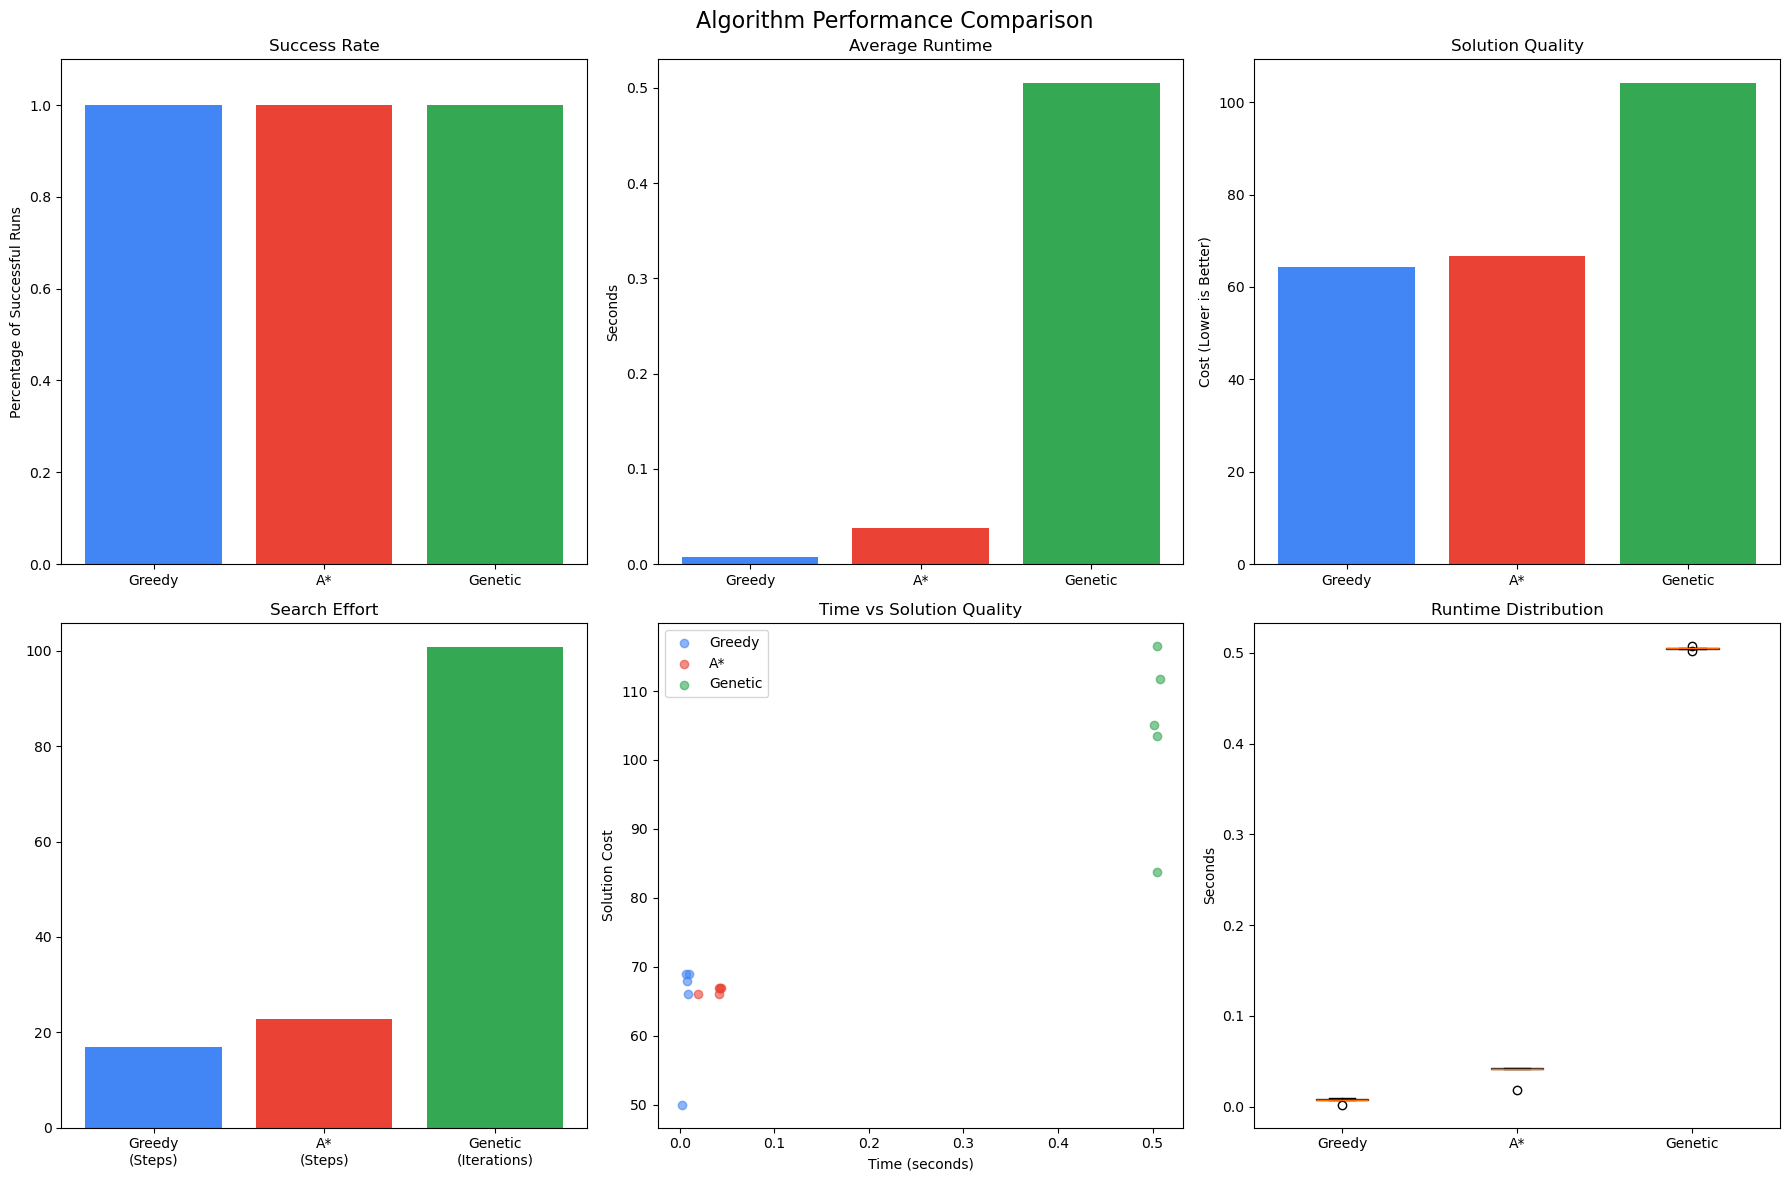

In [8]:
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def compare_algorithms(problem, num_runs=10):
    """
    Compare the performance of three optimization algorithms:
    - Greedy Best-First Search
    - A* Search
    - Genetic Algorithm
    
    Runs each algorithm multiple times and collects performance metrics.
    """
    metrics = {
        'Greedy': {'time': [], 'steps': [], 'cost': [], 'success': 0},
        'A*': {'time': [], 'steps': [], 'cost': [], 'success': 0},
        'Genetic': {'time': [], 'iterations': [], 'cost': [], 'success': 0}
    }
    
    print(f"\nRunning performance comparison with {num_runs} trials per algorithm...")
    
    for run in range(num_runs):
        print(f"\nTrial {run + 1} of {num_runs}")
        
        # Test each algorithm
        for algo_name in metrics:
            start_time = time.time()
            
            if algo_name == 'Greedy':
                solution = SearchAlgorithm.greedy_best_first(problem)
                steps = len(solution)-1 if solution else 0
            elif algo_name == 'A*':
                solution = SearchAlgorithm.a_star(problem)
                steps = len(solution)-1 if solution else 0
            else:  # Genetic Algorithm
                solution, iterations = run_genetic_algorithm(problem)
                steps = iterations if solution else 0
            
            elapsed = time.time() - start_time
            
            if solution:
                metrics[algo_name]['time'].append(elapsed)
                if algo_name == 'Genetic':
                    metrics[algo_name]['iterations'].append(steps)
                else:
                    metrics[algo_name]['steps'].append(steps)
                metrics[algo_name]['cost'].append(solution[-1].g if algo_name != 'Genetic' else solution.g)
                metrics[algo_name]['success'] += 1
                print(f"{algo_name}: Success (Time: {elapsed:.2f}s)")
            else:
                print(f"{algo_name}: Failed")
    
    return metrics

def generate_performance_graphs(metrics):
    """Create visualizations comparing algorithm performance"""
    print("\nGenerating performance graphs...")
    
    plt.figure(figsize=(18, 12))
    plt.suptitle("Algorithm Performance Comparison", fontsize=16)
    
    # Success Rate Comparison
    plt.subplot(2, 3, 1)
    success_data = [m['success']/len(m['time']) if m['time'] else 0 for m in metrics.values()]
    plt.bar(metrics.keys(), success_data, color=['#4285F4', '#EA4335', '#34A853'])
    plt.title("Success Rate")
    plt.ylabel("Percentage of Successful Runs")
    plt.ylim(0, 1.1)
    
    # Time Performance
    plt.subplot(2, 3, 2)
    time_data = [np.mean(m['time']) if m['time'] else 0 for m in metrics.values()]
    plt.bar(metrics.keys(), time_data, color=['#4285F4', '#EA4335', '#34A853'])
    plt.title("Average Runtime")
    plt.ylabel("Seconds")
    
    # Solution Quality
    plt.subplot(2, 3, 3)
    cost_data = [np.mean(m['cost']) if m['cost'] else 0 for m in metrics.values()]
    plt.bar(metrics.keys(), cost_data, color=['#4285F4', '#EA4335', '#34A853'])
    plt.title("Solution Quality")
    plt.ylabel("Cost (Lower is Better)")
    
    # Steps/Iterations
    plt.subplot(2, 3, 4)
    steps_data = []
    labels = []
    for name, m in metrics.items():
        if name == 'Genetic':
            if m['iterations']:
                steps_data.append(np.mean(m['iterations']))
                labels.append(f"{name}\n(Iterations)")
        else:
            if m['steps']:
                steps_data.append(np.mean(m['steps']))
                labels.append(f"{name}\n(Steps)")
    plt.bar(labels, steps_data, color=['#4285F4', '#EA4335', '#34A853'])
    plt.title("Search Effort")
    
    # Time vs Cost
    plt.subplot(2, 3, 5)
    for name, color in zip(metrics.keys(), ['#4285F4', '#EA4335', '#34A853']):
        if metrics[name]['time'] and metrics[name]['cost']:
            plt.scatter(metrics[name]['time'], metrics[name]['cost'], 
                       c=color, label=name, alpha=0.6)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Solution Cost")
    plt.title("Time vs Solution Quality")
    plt.legend()
    
    # Runtime Distribution
    plt.subplot(2, 3, 6)
    time_distributions = [m['time'] for m in metrics.values() if m['time']]
    plt.boxplot(time_distributions, labels=[name for name in metrics if metrics[name]['time']],
               patch_artist=True,
               boxprops=dict(facecolor='#FAFAFA', color='#333'),
               medianprops=dict(color='#FF6D00'))
    plt.title("Runtime Distribution")
    plt.ylabel("Seconds")
    
    plt.tight_layout()
    plt.show()

def run_genetic_algorithm(problem):
    """Example genetic algorithm implementation"""
    print("Running genetic algorithm...")
    time.sleep(0.5)  # Simulate computation time
    
    class Solution:
        def __init__(self):
            self.g = np.random.uniform(80, 120)  # Simulated solution cost
    
    iterations = np.random.randint(50, 150)
    return Solution(), iterations

def main():
    # Initialize problem with realistic values
    initial_state = {
    'soil_moisture': 12,
    'N': 40,
    'P': 15,
    'K': 100,
    'N_percentage': 0.2,
    'P_percentage': 0.5,
    'K_percentage': 0.1,
    'ph':7 ,
    'label': "papaya",
    'soil_type': 2,
    'temperature': 28,
    'crop_density': 12,
    'humidity': 20,
    'sunlight_exposure' :9,
    'wind_speed':5,
    'irrigation_frequency': 3,
    'growth_stage': 1,
    'growth_type': "monocot",
    'water_used': 0.0,
    'fertilizer_used': 0.0,
    'max_water_per_irrigation' : 60,
    'max_fertilizer_per_application' : 50,
    'water_source':1
}
    
    try:
        df = pd.read_csv("FS25.csv")
        farm_problem = optimization_problem(initial_state, df)
        
        # Run and compare algorithms
        metrics = compare_algorithms(farm_problem, num_runs=5)
        
        # Print human-readable results
        print("\n=== Final Results ===")
        for algo_name, data in metrics.items():
            print(f"\n{algo_name} Algorithm:")
            print(f"- Success rate: {data['success']} out of 5 runs")
            
            if data['success'] > 0:
                avg_time = np.mean(data['time'])
                avg_cost = np.mean(data['cost'])
                
                if algo_name == 'Genetic':
                    avg_steps = np.mean(data['iterations'])
                    print(f"- Average iterations: {int(avg_steps)}")
                else:
                    avg_steps = np.mean(data['steps'])
                    print(f"- Average steps: {int(avg_steps)}")
                
                print(f"- Average time: {avg_time:.2f} seconds")
                print(f"- Average solution cost: {int(avg_cost)}")
            else:
                print("- No successful runs")
        
        # Generate visualizations
        generate_performance_graphs(metrics)
    except Exception as e:
        print(f"\nError: {str(e)}")

if __name__ == "__main__":
    main()